In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("resources/RSCCASN.csv", index_col="DATE", parse_dates=True)

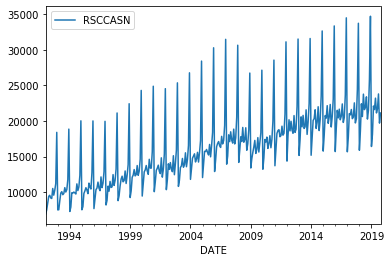

In [7]:
df.plot()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RSCCASN,334.0,16325.095808,5369.839014,6938.0,12298.5,15878.5,19772.5,34706.0


### Setting test size
- using 1.5 years

In [13]:
test_size = 18

In [14]:
test_index = len(df) - test_size

In [17]:
train = df.iloc[:test_index]

In [18]:
len(train)

316

In [20]:
test = df.iloc[test_index:]

## Scaling the data

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scalar = MinMaxScaler()

In [23]:
train_scaled  = scalar.fit_transform(train)

In [24]:
test_scaled = scalar.transform(test)

### Time series generator

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
length = 12
b = 1

In [28]:
generator = TimeseriesGenerator(
data = train_scaled,
    targets = train_scaled,
    length = length,
    batch_size=b,
)

## Testing the generator

In [29]:
X,y = generator[0]

In [30]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [31]:
y

array([[0.02047633]])

In [32]:
len(generator)

304

In [33]:
val_gen =  TimeseriesGenerator(
data = test_scaled,
    targets = test_scaled,
    length = length,
    batch_size=b,
)

### Creating the model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

In [36]:
n_features = 1

In [37]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length,n_features )))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam")

In [38]:
model.fit_generator(generator, validation_data=val_gen, epochs=12, callbacks=[stop])

Epoch 1/12
304/304 [==============================] - 133s 436ms/step - loss: 0.0263 - val_loss: 0.0067
Epoch 2/12
304/304 [==============================] - 128s 422ms/step - loss: 0.0173 - val_loss: 0.0121
Epoch 3/12
304/304 [==============================] - 141s 465ms/step - loss: 0.0108 - val_loss: 0.0151
Epoch 4/12
304/304 [==============================] - 143s 471ms/step - loss: 0.0060 - val_loss: 0.0023
Epoch 5/12
304/304 [==============================] - 121s 399ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 6/12
304/304 [==============================] - 132s 436ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 7/12
304/304 [==============================] - 126s 414ms/step - loss: 0.0012 - val_loss: 1.8554e-04
Epoch 8/12
304/304 [==============================] - 133s 437ms/step - loss: 0.0013 - val_loss: 5.3656e-04
Epoch 9/12
304/304 [==============================] - 132s 435ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 10/12
304/304 [==============================] - 1

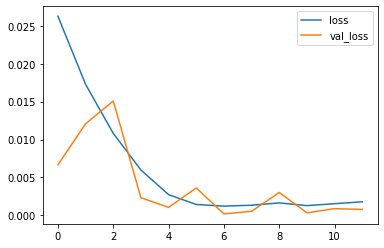

In [40]:
pd.DataFrame(model.history.history).plot()

In [41]:
test_pred = []
batch = train_scaled[-length:]
b_scaled = batch.reshape((1,length,n_features))

for i in range(len(test)):
    pred = model.predict(b_scaled)[0]
    test_pred.append(pred)
    b_scaled = np.append(b_scaled[:,1:,:], [[pred]], axis = 1)

In [42]:
test_pred = scalar.inverse_transform(test_pred)

In [43]:
test["pred"] = test_pred

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


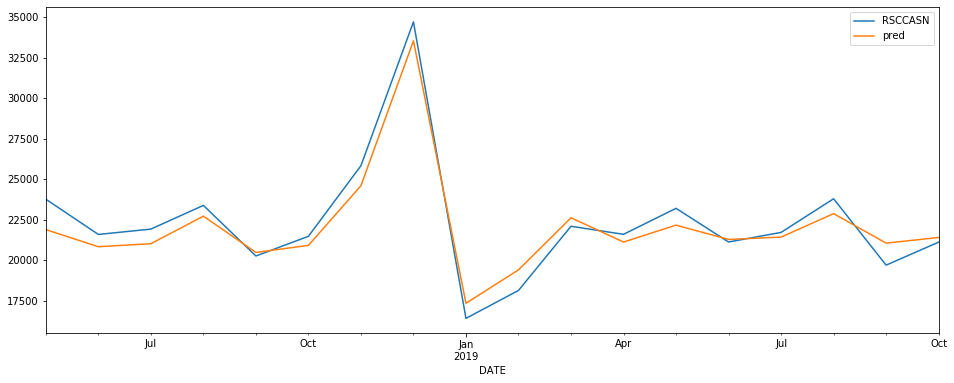

In [44]:
test.plot(figsize = (16,6))

## Picking up the pattern of our data 
- So we can move forward with training on the entire data set 

In [45]:
full_scalar = MinMaxScaler()

In [46]:
data_scaled = full_scalar.fit_transform(df)

In [48]:
full_generator = TimeseriesGenerator(

data_scaled,
    data_scaled,
    length=12,
    batch_size=1,
)

In [49]:
mod = Sequential()
mod.add(LSTM(units = 100, activation = "relu", input_shape = (12,n_features)))
mod.add(Dense(1))
mod.compile(loss = "mse", optimizer = "adam")

In [50]:
mod.fit_generator(full_generator, epochs=12)

Epoch 1/12
322/322 [==============================] - 133s 414ms/step - loss: 0.0249
Epoch 2/12
322/322 [==============================] - 132s 411ms/step - loss: 0.0184
Epoch 3/12
322/322 [==============================] - 132s 410ms/step - loss: 0.0115
Epoch 4/12
322/322 [==============================] - 132s 410ms/step - loss: 0.0043
Epoch 5/12
322/322 [==============================] - 132s 410ms/step - loss: 0.0026
Epoch 6/12
322/322 [==============================] - 132s 410ms/step - loss: 0.0020
Epoch 7/12
322/322 [==============================] - 132s 409ms/step - loss: 0.0018
Epoch 8/12
322/322 [==============================] - 132s 411ms/step - loss: 0.0015
Epoch 9/12
322/322 [==============================] - 149s 464ms/step - loss: 0.0024
Epoch 10/12
322/322 [==============================] - 157s 489ms/step - loss: 0.0014
Epoch 11/12
322/322 [==============================] - 157s 488ms/step - loss: 0.0014
Epoch 12/12
322/322 [==============================] - 157s 488

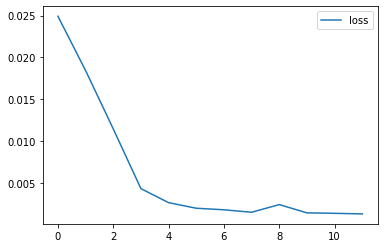

In [52]:
pd.DataFrame(mod.history.history).plot()

In [53]:
forecast = []
periods = 12
bb = data_scaled[-length: ]
bb_scaled = bb.reshape((1,length, n_features))

for i in range(periods):
    p = mod.predict(bb_scaled)[0]
    forecast.append(p)
    bb_scaled = np.append(bb_scaled[:,1:,:], [[p]], axis = 1)

In [54]:
forecast

[array([0.71037006], dtype=float32),
 array([1.0431976], dtype=float32),
 array([0.41428027], dtype=float32),
 array([0.46833128], dtype=float32),
 array([0.5831268], dtype=float32),
 array([0.5730805], dtype=float32),
 array([0.62431514], dtype=float32),
 array([0.5650939], dtype=float32),
 array([0.58437], dtype=float32),
 array([0.6466946], dtype=float32),
 array([0.52976793], dtype=float32),
 array([0.5694272], dtype=float32)]

In [55]:
f = full_scalar.inverse_transform(forecast)

In [56]:
f

array([[26663.55593109],
       [35905.51184082],
       [18441.73441434],
       [19942.62291002],
       [23130.26452065],
       [22851.29877138],
       [24273.98288059],
       [22629.52671909],
       [23164.78663349],
       [24895.41566896],
       [21648.59589434],
       [22749.85427332]])

### now thst we have the values 
- We need to sdd them in with. atimestamp
- start should be the next month after the end of the trainn set 
- Pandas date range frequency strings

In [60]:
df.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [61]:
forecast_index = pd.date_range(start= "2019-11-01",periods= periods,  freq="MS")

In [69]:
forecast_df = pd.DataFrame(f, index=forecast_index, columns= ["forecast"])

In [70]:
forecast_df

,forecast
2019-11-01,26663.555931
2019-12-01,35905.511841
2020-01-01,18441.734414
2020-02-01,19942.622910
2020-03-01,23130.264521
2020-04-01,22851.298771
2020-05-01,24273.982881
2020-06-01,22629.526719
2020-07-01,23164.786633
2020-08-01,24895.415669


(552, 609)

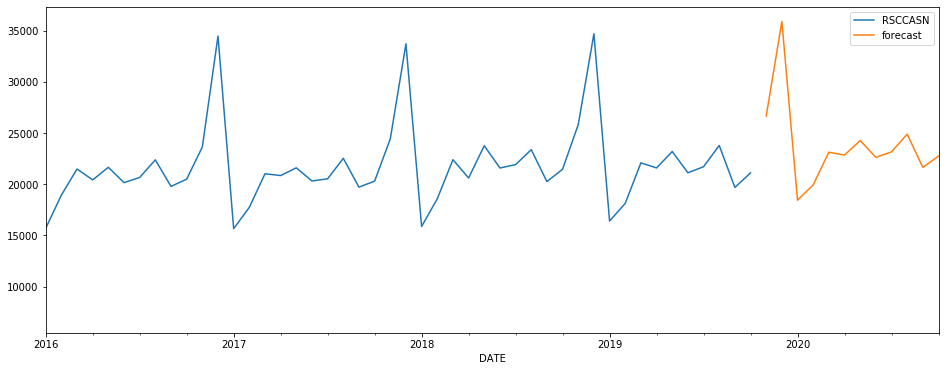

In [75]:
ax = df.plot(figsize = (16,6))
forecast_df.plot(ax = ax)
plt.xlim("2016-1-1","2020-10-1")